# Tutorial: Fine-Tuning ResNet with BlobDatabase

In this tutorial, we will walk through the process of training a Deep Learning model to classify blobs using data stored in Blob Databases. 

### What we will cover:
1.  **Concepts**: Understanding Transfer Learning and ResNet.
2.  **Data Preparation**: Using `BlobDatabase` to create PyTorch Datasets with a proper train/validation split.
3.  **Model Setup**: Modifying a pre-trained ResNet50 for our specific classes.
4.  **Training**: The training loop with validation.
5.  **Export**: Saving the model to ONNX format for deployment.

### Prerequisites
A Blob Database with reference classes assigned to blobs.

And install the required libraries:
```bash
pip install videometer torch torchvision scikit-learn onnx onnxruntime
```

Notice that if you wish to use your GPU for training, then PyTorch might need to be installed from a different package source. [Consult the PyTorch website](https://pytorch.org/get-started/locally/). 

## 1. Concepts: Why ResNet and Transfer Learning?

**ResNet (Residual Network)** is a powerful convolutional neural network architecture that uses "skip connections" to allow gradients to flow easily during training. This enables the training of very deep networks (like the 50-layer version we will use) without the performance degrading.

**Fine-Tuning (Transfer Learning)** is the technique of taking a model already trained on a massive dataset (like ImageNet, with 1.2 million images) and adapting it to a new, smaller task. 

* **Why?** The early layers of the network have already learned to detect edges, textures, and shapes. We only need to "teach" the final layers to recognize the specific difference between your classes. This requires far less data and training time than starting from scratch.

## 2. Setup and Imports

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
import numpy as np
import onnxruntime
import os
import time
import copy
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from videometer.BlobDatabase import BlobDatabase, BlobDataset

## 3. Data Loading and Splitting

We need to create two separate datasets: one for **training** (where the model learns) and one for **validation** (where we check its progress).

We will use a **robust splitting strategy**:
1.  Extract the list of all blob IDs and their labels.
2.  Shuffle and split these IDs.
3.  Create two separate `BlobDataset` objects.
4.  Apply standard **Normalization** to the validation set.

In [3]:
# 1. Initialize Database
db_path = r"C:\Users\CUH\OneDrive - videometer.com\Documents\Videometer\PersonalWorkspaces\All seeds\Blobs\BlobCollections\Cereal Crop.blobdb"
db = BlobDatabase(db_path)

# 2. Get the raw list of samples (IDs and Labels) without loading images yet
# We use a temporary dataset wrapper to fetch the index map efficiently
temp_ds = db.get_dataset(target_class_type="reference")
all_samples = temp_ds.samples
class_map = temp_ds.class_map
num_classes = len(class_map)

print(f"Found {len(all_samples)} samples.")
print(f"Classes: {class_map}")

# 3. Split IDs into Train (80%) and Validation (20%)
train_samples, val_samples = train_test_split(all_samples, test_size=0.2, random_state=42, stratify=[s[1] for s in all_samples])

print(f"Training count: {len(train_samples)}")
print(f"Validation count: {len(val_samples)}")

# 4. Define Transforms
# ImageNet stats for normalization
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(norm_mean, norm_std)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(norm_mean, norm_std)
])

# 5. Create Datasets using the factory constructor logic
train_dataset = BlobDataset(db_path, train_samples, class_map, transform=train_transforms)
val_dataset = BlobDataset(db_path, val_samples, class_map, transform=val_transforms)

# 6. Create DataLoaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

Created dataset with 1400 samples across 7 classes.
Classes: {'Avena Sativa (Oats)': 0, 'Avena Strigosa': 1, 'Hordeum Vulgare (Barley)': 2, 'Orvza Sativa (Rice)': 3, 'Secale Cereale (Rye)': 4, 'Triticum Aestivum (Wheat)': 5, 'Zea Mays (Corn)': 6}
Found 1400 samples.
Classes: {0: 'Avena Sativa (Oats)', 1: 'Avena Strigosa', 2: 'Hordeum Vulgare (Barley)', 3: 'Orvza Sativa (Rice)', 4: 'Secale Cereale (Rye)', 5: 'Triticum Aestivum (Wheat)', 6: 'Zea Mays (Corn)'}
Training count: 1120
Validation count: 280


## 4. Model Setup

We load a pre-trained **ResNet50**. 
The original model outputs 1000 classes (for ImageNet). We must replace the final fully connected layer (`fc`) to output `num_classes` (the number of classes in your database).

In [4]:
# Detect device (CUDA, MPS for Mac, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ResNet50
model = models.resnet50(weights='IMAGENET1K_V1')

# Modify the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move model to GPU/CPU
model = model.to(device)

Using device: cuda


## 5. Visualize features

After loading the model, we perform feature extraction to analyze how well the learned representations separate the different classes. By reducing the high-dimensional features to 2D using techniques like PCA or t-SNE, we can visualize the embeddings and assess whether the model has learned discriminative representations that make the classes more easily separable for classification.

In [ ]:

model_test = nn.Sequential(*list(model.children())[:-1])
model_test.eval()

features_arr = []

for i in range(len(train_dataset)):
    sample_img, _ = train_dataset[i]

    image_tensor = sample_img.unsqueeze(0)  # Add batch dimension: [1, 3, 224, 224]

    # Extract features
    with torch.no_grad():
        features = model_test(image_tensor)
        features_arr.append(features.squeeze().numpy())  # Remove batch and spatial dimensions

features_arr_np = np.array(features_arr)

Features array shape: (1120, 2048)


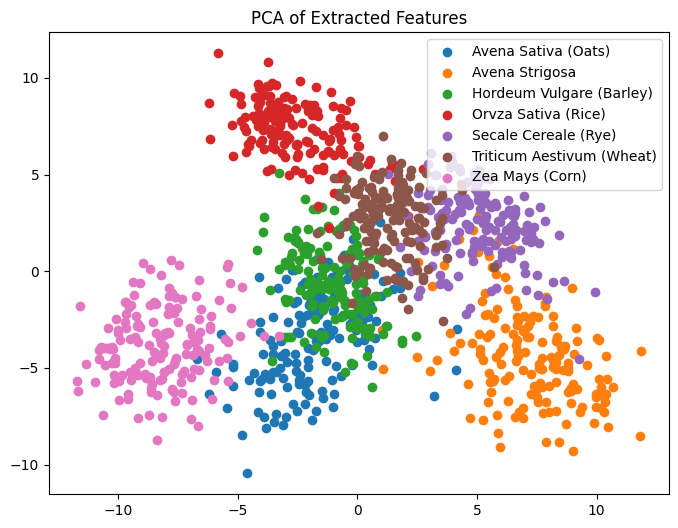

In [ ]:

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_arr_np)

plt.figure(figsize=(8, 6))
for class_idx in range(num_classes):
    class_features = reduced_features[[i for i, s in enumerate(train_samples) if s[1] == class_idx]]
    plt.scatter(class_features[:, 0], class_features[:, 1], label=class_map[class_idx])
plt.legend()
plt.title("PCA of Extracted Features")
plt.show()



Reduced features (TSNE) shape: (1120, 2)


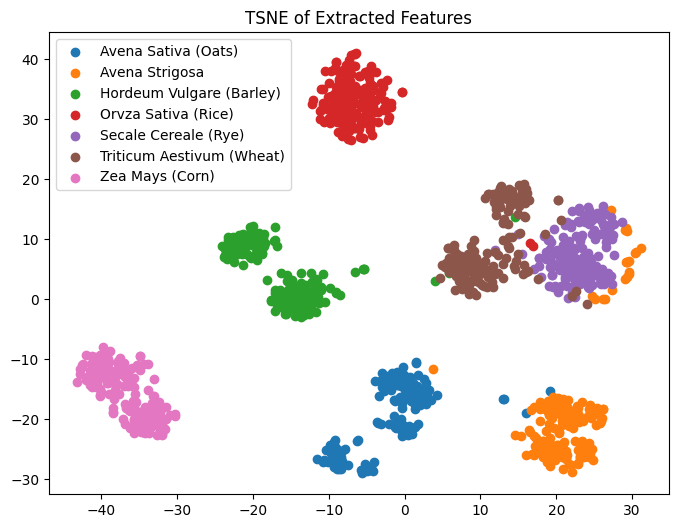

In [10]:
tsne = TSNE(n_components=2, random_state=42)
reduced_features_tsne = tsne.fit_transform(features_arr_np)
print(f"Reduced features (TSNE) shape: {reduced_features_tsne.shape}")

plt.figure(figsize=(8, 6))
for class_idx in range(num_classes):
    class_features = reduced_features_tsne[[i for i, s in enumerate(train_samples) if s[1] == class_idx]]
    plt.scatter(class_features[:, 0], class_features[:, 1], label=class_map[class_idx])
plt.legend()
plt.title("TSNE of Extracted Features")
plt.show()

## 6. Training Loop

We define the logic to train the model. This includes:
1.  **Forward Pass**: Compute predictions.
2.  **Loss Calculation**: Compare prediction to truth (CrossEntropy).
3.  **Backward Pass**: Calculate gradients.
4.  **Optimizer Step**: Update weights.

We save the best model weights based on validation accuracy.

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train' and scheduler:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best one so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# Setup Loss and Optimizer
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# Using SGD with momentum is standard for ResNet fine-tuning
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Run Training
trained_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.9307 Acc: 0.5000
val Loss: 0.9088 Acc: 0.6667

Epoch 1/4
----------
train Loss: 0.6098 Acc: 0.7000
val Loss: 0.9531 Acc: 0.6667

Epoch 2/4
----------
train Loss: 0.3285 Acc: 0.9000
val Loss: 0.5772 Acc: 0.6667

Epoch 3/4
----------
train Loss: 0.3514 Acc: 0.9000
val Loss: 0.3763 Acc: 0.8333

Epoch 4/4
----------
train Loss: 0.1907 Acc: 0.9500
val Loss: 0.2705 Acc: 0.8333

Training complete in 4m 1s
Best val Acc: 0.833333


## 7. Export to ONNX

ONNX (Open Neural Network Exchange) is a standard format for representing machine learning models. Exporting to ONNX allows you to use this model for classification in VideometerLab.

We specify `dynamic_axes` to allow the batch size to vary (e.g., process 1 image or 100 images at once).

In [13]:
ONNX_PATH = "blob_resnet50.onnx"

# 1. Create a dummy input matching the input size (1 batch, 3 channels, 224x224)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# 2. Export
torch.onnx.export(
    trained_model,
    dummy_input,
    ONNX_PATH,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},  # Variable length axes
        'output': {0: 'batch_size'}
    },
    dynamo=False
)
print(f"Model exported to {ONNX_PATH}")

C:\Users\heh\AppData\Local\Temp\ipykernel_31500\2037365576.py:7: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Model exported to blob_resnet50.onnx


## 8. Verify ONNX Model

It is best practice to verify that the exported model produces the same results as the PyTorch model. We utilize `onnxruntime` for this verification.

In [12]:
# 1. Run inference with PyTorch
trained_model.eval()
with torch.no_grad():
    torch_out = trained_model(dummy_input)

# 2. Run inference with ONNX Runtime
ort_session = onnxruntime.InferenceSession(ONNX_PATH, providers=['CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)

# 3. Compare
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)
print("✅ Exported model has been tested with ONNXRuntime, and the result looks good!")

✅ Exported model has been tested with ONNXRuntime, and the result looks good!
